In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il
import pandas as pd

#intitial setup
basePath = "../data/tng-100-3/output"
fields = {"stars": ["Coordinates", "Potential", "Masses", "Velocities"],
        "gas": ["Coordinates", "Potential", "Masses", "Velocities"],
        "dm": ["Coordinates", "Potential"]
        }
indices = [544, 953, 1285, 1662, 2383] #[1893, 2164, 3043, 3229, 3403, 3605, 3760] 
#np.genfromtxt("./data/tng-100-3/cutdata/early_type_indices.csv")
DM_PARTICLE_MASS = 0.03235675 #found in header of snapshot
N = len(indices)
stars = [0]*N
gas = [0]*N
dm = [0]*N
particle_lists= [gas, dm, stars]
group_cat = pd.DataFrame({"id": indices})


In [2]:
def radius(df):
    x = np.array(df["x"])
    y = np.array(df["y"])
    z = np.array(df["z"])
    r = (x**2 + y**2 + z**2)**(1/2)
    return r

In [3]:
#Load all particles
for i in range(N):
    stars[i] = il.pandasformat.dict_to_pandas(il.snapshot.loadSubhalo(basePath, 99, indices[i], 'stars', fields["stars"]))
    gas[i] = il.pandasformat.dict_to_pandas(il.snapshot.loadSubhalo(basePath, 99, indices[i], 'gas', fields["gas"]))
    dm[i] = il.pandasformat.dict_to_pandas(il.snapshot.loadSubhalo(basePath, 99, indices[i], 'dm', fields["dm"]))
    dm[i]["Masses"] = [DM_PARTICLE_MASS]*len(dm[i]["Potential"])


subhaloFields = ["SubhaloMass", 'SubhaloMassType', "SubhaloMassInHalfRadType", "SubhaloHalfmassRadType", "SubhaloPos", "SubhaloVel", "SubhaloSpin"]
subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=subhaloFields)
df_subhalos = il.pandasformat.dict_to_pandas(subhalos)

In [4]:
#calculate radius
def particle_radii(particles, N, catalogue):
    center_of_mass = np.zeros([N,3])
    for i in range(N):
        #find center of halo
        min_pot = 0
        for particle in particles:
            #Find particle with lowest potential
            min_pot_value = particle[i]["Potential"].min()
            if min_pot_value < min_pot:
                min_pot = min_pot_value
                #Get particle position and assign as center of galaxy
                min_pot_pos = particle[i][particle[i]["Potential"] == min_pot_value]["Coordinates"].values[0]
        
        center_of_mass[i] = min_pot_pos
        #Calculate new coordinates
        for particle in particles:
            particle[i]["x"] = particle[i]["X"] - min_pot_pos[0]
            particle[i]["y"] = particle[i]["Y"] - min_pot_pos[1]
            particle[i]["z"] = particle[i]["Z"] - min_pot_pos[2]
            particle[i]["r"] = radius(particle[i])
    #Save to group catalogue
    catalogue["CenterOfMassX"] = center_of_mass[:,0]
    catalogue["CenterOfMassY"] = center_of_mass[:,1]
    catalogue["CenterOfMassZ"] = center_of_mass[:,2]
    return particles, catalogue
particle_lists, group_cat = particle_radii(particle_lists, N, group_cat)

In [6]:
#Calculate total mass for each particle type
def total_mass(particles, N, catalogue):
    particle_mass = np.zeros([len(particles), N])
    p = 0
    for particle in particles:
        for i in range(N):
            particle_mass[p][i] = particle[i]["Masses"].sum() #or load from snapshot to save time
        p = p + 1
    total_mass = particle_mass.sum()

    #save value to catalogue
    catalogue["SubhaloMassGas"] = particle_mass[0]
    catalogue["SubhaloMassDM"] = particle_mass[1]
    catalogue["SubhaloMassStellar"] = particle_mass[2]
    catalogue["SubhaloMass"] = total_mass
    return particles, catalogue
    
particle_lists, group_cat = total_mass(particle_lists, N, group_cat)


In [30]:
def subhalo_velocity(particles, N, catalogue):
    for i in range(N):
        v_avg = np.zeros([len(particles), 3])
        j = 0
        for particle in particles:
            m = np.array(particle[i]["Masses"])
            M = m.sum()
            print(particle[i].keys())
            velocities = particle[i]["Velocities"].values
            vx_avg = np.array([item[0] for item in velocities])*m/M
            vy_avg = np.array([item[1] for item in velocities])*m/M
            vz_avg = np.array([item[2] for item in velocities])*m/M
            v_avg[j] = [vx_avg.mean(), vy_avg.mean(), vz_avg.mean()]
            j = j + 0
        v_avg_tot = v_avg.mean()
        print(v_avg_tot)
particle_lists, group_cat = subhalo_velocity(particle_lists, N, group_cat)

Index(['count', 'Coordinates', 'Potential', 'Masses', 'Velocities', 'X', 'Y',
       'Z', 'x', 'y', 'z', 'r', 'x_rot', 'y_rot', 'z_rot'],
      dtype='object')
Index(['count', 'Coordinates', 'Potential', 'X', 'Y', 'Z', 'Masses', 'x', 'y',
       'z', 'r', 'x_rot', 'y_rot', 'z_rot'],
      dtype='object')


KeyError: 'Velocities'

In [25]:
def relative_velocities(particle, N, catalogue):
    central_vel = np.zeros([N,3])
    for i in range (N):
        velocities = particle[i]["Velocities"].values
        particle[i]["Vx_pec"] = np.array([item[0] for item in velocities])
        particle[i]["Vy_pec"] = np.array([item[1] for item in velocities])
        particle[i]["Vz_pec"] = np.array([item[2] for item in velocities])
        vel_av = [particle[i]["Vx_pec"].mean(), particle[i]["Vy_pec"].mean(), particle[i]["Vz_pec"].mean()]
        particle[i]["Vx"] = particle[i]["Vx_pec"] - vel_av[0]
        particle[i]["Vy"] = particle[i]["Vy_pec"] - vel_av[1]
        particle[i]["Vz"] = particle[i]["Vz_pec"] - vel_av[2]
        print(vel_av)
    return particle, catalogue
stars, group_cat = relative_velocities(stars, N, group_cat)

[-194.30988, 398.32654, -2.7282262]
[228.88022, -119.55794, 61.712532]
[81.71066, 73.156006, 214.40471]
[-16.901888, 390.49814, 235.63263]
[22.80535, -55.03292, 200.05794]


In [24]:
for i in range(N):
    #print(stars[i][stars[i]["r"] < 50]["Vz"].max())
    print(subhalos["SubhaloVel"][indices[i]])

[-175.13785    81.367256   -8.339443]
[279.23257  -99.84879   82.072495]
[174.64732  57.31744 170.41402]
[ 99.0264  291.83783 138.21898]
[ 78.93291 105.77122 116.54212]


In [7]:
j = 0
for i in indices: 
    print("Group catalogue: ", df_subhalos["SubhaloMassStellar"][i], " Snapshot: ", group_cat["SubhaloMassStellar"][j])
    j = j +1

Group catalogue:  80.1757  Snapshot:  80.17588806152344
Group catalogue:  90.369896  Snapshot:  90.3699951171875
Group catalogue:  43.96099  Snapshot:  43.97459030151367
Group catalogue:  42.83398  Snapshot:  42.84111404418945
Group catalogue:  71.43518  Snapshot:  71.46080017089844


In [8]:
def half_mass_radius(particle, N, catalogue):
    #Calculate half mass radius
    halfmass_rad = np.zeros(N)
    for i in range(N):
        temp = particle[i].copy(deep=True)
        temp = temp.sort_values(by="r")
        temp_mass = 0
        n = temp["count"][0]
        r_max = 40
        r = 0
        for j in range(n):
            if temp_mass < (catalogue["SubhaloMassStellar"][i]/2):
                temp_mass = temp_mass + temp["Masses"][j]
            else:
                m1 = temp["Masses"][j-1]
                m2 = temp["Masses"][j]
                M = m1+m2
                halfmass_rad[i] = (m1*temp["r"][j-1] + m2*temp["r"][j])/M #some uncertainty here, now center of mass
                break  
    catalogue["SubhaloHalfmassRadStellar"] = halfmass_rad
    return particle, catalogue

stars, group_cat = half_mass_radius(stars, N, group_cat)

In [9]:
j = 0
for i in indices: 
    print("Group catalogue: ", df_subhalos["SubhaloHalfmassRadStellar"][i], " Snapshot: ", group_cat["SubhaloHalfmassRadStellar"][j])
    j = j +1

Group catalogue:  64.70497  Snapshot:  57.03927079687098
Group catalogue:  79.047134  Snapshot:  81.96062358633587
Group catalogue:  33.925236  Snapshot:  43.439945028308486
Group catalogue:  40.62605  Snapshot:  42.503865196913104
Group catalogue:  39.33135  Snapshot:  39.48556364043907


In [10]:
def max_ang_momentum(particle, N, catalogue):
    max_L_dir = np.zeros([N, 3])
    i = 0
    for subhalo in particle:
        r_max = 10*catalogue["SubhaloHalfmassRadStellar"][i]
        temp = subhalo[subhalo["r"] < r_max]
        #print(r_max)
        v = np.array([np.array(temp["Vx"]), np.array(temp["Vy"]), np.array(temp["Vz"])])
        r = np.array([np.array(temp["x"]), np.array(temp["y"]), np.array(temp["z"])])
        m = np.array(temp["Masses"])
        Lx =  m*(r[1]*v[2] - r[2]*v[1])
        Ly =  m*(r[2]*v[0] - r[0]*v[2])
        Lz =  m*(r[0]*v[1] - r[1]*v[0])
        L = (Lx**2 + Ly**2 + Lz**2)**(1/2)
        L_max, L_max_index = L.max(), L.argmax()
        max_L_dir[i] = [Lx[L_max_index], Ly[L_max_index], Lz[L_max_index]]/L_max
        print(v[0][L_max_index], v[1][L_max_index], v[2][L_max_index])
        i = i + 1
    return max_L_dir
max_L = max_ang_momentum(stars, N, group_cat)
group_cat["RotationAxisX"] = [item[0] for item in max_L]
group_cat["RotationAxisY"] = [item[1] for item in max_L]
group_cat["RotationAxisZ"] = [item[2] for item in max_L]


1194.2264 -1598.9983 -681.0006
1563.5499 371.16962 -147.76442
93.46825 1388.7336 239.73799
1155.5414 -1126.7684 -805.79285
-254.17363 1420.9067 -837.17804


In [12]:

def rotate_basis(old_basis, new_z_axis):
    def rotation_matrix(alpha, beta, gamma):
        R_z = [[np.cos(gamma), -np.sin(gamma), 0], [np.sin(gamma), np.cos(gamma), 0], [0, 0, 1]]
        R_y = [[np.cos(beta), 0, np.sin(beta)], [0, 1, 0], [np.sin(beta), 0, np.cos(beta)]]
        R_x = [[1, 0, 0], [0, np.cos(alpha), np.sin(alpha)], [0, np.sin(alpha), np.cos(alpha)]]
        R = np.linalg.multi_dot([R_z, R_y, R_x])
        return R
    L = new_z_axis
    L_xy = np.array([L[0], L[1], 0])
    L_len = np.linalg.norm(L)
    L_xy_len = np.linalg.norm(L_xy)
    new_basis = np.zeros([3,3])
    #Get rotation angles
    theta = np.nan_to_num(np.arccos(np.dot(L, old_basis[:, 2])/L_len)) #get angle between new z axis and old z axis
    phi = np.nan_to_num(np.arccos(np.dot(L_xy, old_basis[:, 0])/L_xy_len)) #get angle between projected new z axis and old x axis
    #print(np.degrees(theta), np.degrees(phi))
    #Create rotation matrix
    #Rotate phi radians about z and theta radians about y
    new_basis = rotation_matrix(phi, theta, 0)
    
    return new_basis


In [13]:
def rotate_coordinates(particles, N, catalogue):
    rot_vector = np.transpose(np.array([group_cat["RotationAxisX"], group_cat["RotationAxisY"], group_cat["RotationAxisZ"]]))
    for i in range (N):
            new_basis = rotate_basis(np.identity(3), rot_vector[i])
            print(i)
            for particle in particles:
                old_positions = np.transpose(np.array([particle[i]["x"], particle[i]["y"], particle[i]["z"]]))
                new_positions = np.zeros([len(old_positions), 3])
                for j in range(len(old_positions)): #If this could be done faster, code would improve
                    new_positions[j] = np.dot(new_basis, old_positions[j])
                new_positions = np.transpose(new_positions)
                particle[i]["x_rot"] = new_positions[0]
                particle[i]["y_rot"] = new_positions[1]
                particle[i]["z_rot"] = new_positions[2]
    return particles
particle_lists = rotate_coordinates(particle_lists, N, group_cat)

#print(group_cat["RotationAxisX"])

0
1
2
3
4


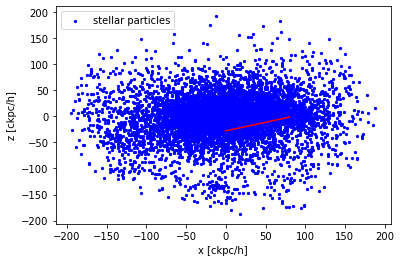

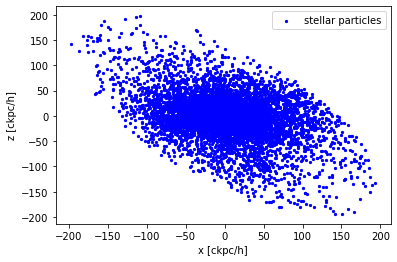

In [21]:
g=0
plt.scatter(stars[g][stars[g]["r"] < 200]["x"], stars[g][stars[g]["r"] < 200]["z"], c = "blue", s=5, alpha = 1, label ="stellar particles")
plt.plot([80, 0],[group_cat["RotationAxisX"][g]*30, group_cat["RotationAxisZ"][g]*30], c = "red")
#plt.xlim([800, 1000])
#plt.ylim([26550, 26750])
plt.xlabel('x [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.legend()
plt.show()

plt.scatter(stars[g][stars[g]["r"] < 200]["x_rot"], stars[g][stars[g]["r"] < 200]["z_rot"], c = "blue", s=5, alpha = 1, label ="stellar particles")

#plt.xlim([800, 1000])
#plt.ylim([26550, 26750])
plt.xlabel('x [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.legend()
plt.show()

In [23]:
rot_vector = np.transpose(np.array([group_cat["RotationAxisX"], group_cat["RotationAxisY"], group_cat["RotationAxisZ"]]))
for i in range(N):
    #print(stars[i][stars[i]["r"] < 50]["Vz"].max())
    print(subhalos["SubhaloVel"][indices[i]])

[-175.13785    81.367256   -8.339443]
[279.23257  -99.84879   82.072495]
[174.64732  57.31744 170.41402]
[ 99.0264  291.83783 138.21898]
[ 78.93291 105.77122 116.54212]


In [16]:
rot_vector = np.transpose(np.array([group_cat["RotationAxisX"], group_cat["RotationAxisY"], group_cat["RotationAxisZ"]]))
for i in range(N):
    #print(stars[i][stars[i]["r"] < 50]["Vz"].max())
    print(rot_vector[i])
    print(subhalos["SubhaloSpin"][indices[i]])

[-0.05347825  0.35720151 -0.93249512]
[  5433.1855 -16689.023  -17918.355 ]
[ 0.22682839 -0.97294945 -0.04379784]
[ 11245.203  -4579.789 -60716.664]
[ 0.26860951 -0.18139006  0.94601616]
[ -9870.022 -25605.318  20182.049]
[-0.31625335 -0.74465983  0.58776318]
[ -1332.2336 -38814.52    55159.414 ]
[ 0.60149752 -0.3229214  -0.73070001]
[ -9793.44   70351.83  -28444.508]
